In [124]:
import numpy
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import interp2d
import matplotlib.gridspec as gridspec


In [193]:
#Finds distance of a point from another point (cen)
def dist_pt_cent(pt,cen):
    #just check if the two inputs have the same dimension
    if(len(pt)!=len(cen)):
        raise Exception('pt and cen lengths do not match. The length of pt was: {}'.format(len(pt)))
    dist_vec = list(map(lambda x,y: x-y, pt,cen))
    dist_vec = list(map(lambda x: x*x ,dist_vec))
    #print(dist_vec)    
    dist = math.sqrt(sum(dist_vec))
    return dist


#Input distance of point from two centers d1 and d2
#      distance between the two centers r12
#      radii of the two atomic grids
#      becke switching function order (usually 3)
def find_becke_fac(d1,d2,r12,radii,order):
    diff=(d1-d2)/r12
    #print('diff:',diff,'r12:',r12)
    a12 = radii[0]/radii[1]
    a12 =1.0/a12 - a12
    a12 = 0.25 * a12
    if (abs(a12)>0.5):
        a12 = 0.5 * np.sign(a12)
    #print('a12:',a12)    
    fac = diff + a12*(1-diff*diff)
    for i in range(order):
        s=(1.5-0.5*fac*fac)*fac
        fac = s
        #print(i,'fac:',fac)
    return fac

#On input: 
#pt: set of points in 2d
#cen: 2d center of atoms list
#radii: radaii of at atomic grids
#order: order of becke switching (usually 3)
# output is a one dimensional array of size pt
# containing weights
def form_becke_weights(pt,cen,radii,order):
    dist_mat=numpy.zeros((len(pt),len(cen)))
    becke_weights = numpy.zeros((len(pt),len(cen)))
    p = numpy.zeros(len(cen))
    
    
    for i in range(len(pt)):
        for j in range(len(cen)):
            #print(i,j)
            #print(pt[i])
            #print(cen[j])
            dist_mat[i,j] = dist_pt_cent(pt[i],cen[j])
            #print(dist_mat)
        p=numpy.empty(len(cen)); p.fill(1.0)    
        for j in range(len(cen)):
            for k in range(len(cen)):
                if(k!=j):
                    r_jk = dist_pt_cent(cen[j],cen[k])
                    #print(j,k,'rjk:',r_jk)
                    fac = find_becke_fac(dist_mat[i,j],dist_mat[i,k],r_jk,radii,order)
                    #print('fac:',fac)
                    p[j]=p[j]*0.5*(1.0-fac)
                    p[k]=p[k]*0.5*(1.0+fac)
        norm = 0.0            
        for icen in range(len(cen)):
            #print('p:','icen:',icen,p[icen])
            norm = norm + p[icen]
            
        pb = list(map(lambda x:x/norm , p))
        
        #add Luca reweighting
        #for icen in range(len(cen)):
        #    if(dist_mat[i,icen]!=0.0):
        #        pb[icen]=pb[icen]*numpy.exp(1.e-40*(radii[icen]/dist_mat[i,icen])**10)

        
        
        for icen in range(len(cen)):
            becke_weights[i,icen] = pb[icen]
            
        #print("norm:",norm)
        
    return becke_weights


#dot product of two vectors
def dot(K, L):
    if len(K) != len(L):
        return 0

    return sum(i[0] * i[1] for i in zip(K, L))

###Test of a_ij and Bragg_Slater radii
def get_scale_factor(radii):
    cen_num = len(radii) 
    #a = numpy.zeros(shape=(cen_num,cen_num))
    ans = numpy.zeros(shape=(cen_num,cen_num))
    for i in range(len(radii)):
        for j in range(len(radii)):
            ratio = radii[i]/ radii[j]
            u = (ratio - 1)/(ratio + 1)
            a = u / (u * u - 1 )
            if(i!=j):
                ans[i][j] = -0.5*(-1 + numpy.sqrt(1+4*a*a)) / a
                if(ans[i][j]<0):
                    ans[i][j]=1+ans[i][j]
            else:
                ans[i][j] = 0.5
                

    return ans

def modify_becke(pt,bw,cen,radii):
    print(bw.shape)
    n = 5
    dist_mat=numpy.zeros((len(pt),len(cen)))
    x = numpy.zeros((len(pt),len(cen)))
    for i in range(len(pt)):
        for j in range(len(cen)):

            dist_mat[i,j] = dist_pt_cent(pt[i],cen[j])    
        
    dim1=bw.shape[0]
    dim2=bw.shape[1]
    wc = numpy.zeros((dim1))
    epsilon = numpy.log(1.e-20)
    
    
    
    for i in range(dim1):
        for icen in range(dim2):
            x[i,icen] = dist_mat[i,icen]/radii[icen]
            x[i,icen] = x[i,icen] ** (2. * n)
            bw[i,icen] = bw[i,icen]*numpy.exp( epsilon * x[i,icen])
            wc[i] = wc[i] + bw[i,icen]
        wc[i] = 1. - wc[i]
        
    return wc, bw

def modify_becke2(pt,bw,cen,radii):
    print(bw.shape)
    n = 4
    dist_mat=numpy.zeros((len(pt),len(cen)))
    x = numpy.zeros((len(pt)))
    dim1=bw.shape[0]
    dim2=bw.shape[1]
    wc = numpy.zeros((dim1))

    for i in range(len(pt)):
        for j in range(len(cen)):

            dist_mat[i,j] = dist_pt_cent(pt[i],cen[j])                     
    
    for i in range(dim1):
        for icen in range(dim2):
            x[i] = x[i] + 1./dist_mat[i,icen]
        x[i] = x[i] ** (2. * n)
                    
    for i in range(dim1):
        for icen in range(dim2):                    
            bw[i,icen] = bw[i,icen]*numpy.exp( - (1./x[i]))
            wc[i] = wc[i] + bw[i,icen]
        wc[i] = 1. - wc[i]
        
    return wc, bw

In [85]:
grid_z, grid_y = numpy.mgrid[-5:5:500j, -5:5:500j]
print(len(grid_z)); print(len(grid_y))
print(range(len(grid_z)))
#print(grid_z[0,149],grid_y[0,1])
# for i in zip(grid_z,grid_y):
#     for j in zip(i[0],i[1]):
#         print(j[0],j[1])


500
500
range(0, 500)


In [39]:
def make_2d_pts(x,y):
    pt=[]
    for i in zip(grid_z,grid_y):
        for j in zip(i[0],i[1]):
            pt.append([j[0],j[1]])
    return pt        
                       

In [86]:
pt=make_2d_pts(grid_z, grid_y)
cen = [[1.,0],[-1,0]]
radii = [10., 10.]
order = 3
w = form_becke_weights(pt,cen,radii,order)

In [87]:
print(w[1])
w1 = [item[0] for item in w ]
w2 = [item[1] for item in w ]
print(w1[1], w2[1])
print(len(w1))

[8.83559537e-08 9.99999912e-01]
8.83559536714375e-08 0.9999999116440463
250000


In [104]:
wb1=numpy.reshape(w1, (len(grid_z[0]), len(grid_z))).T
wb2 = numpy.reshape(w2, (len(grid_z[0]), len(grid_z))).T

In [66]:
250*150

37500

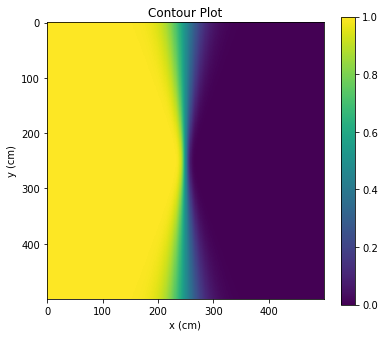

In [105]:
fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])
cp = plt.imshow( wb2)#,origin='lower',vmin=0,vmax=max(w2))
plt.colorbar(cp)

ax.set_title('Contour Plot')
ax.set_xlabel('x ')
ax.set_ylabel('y ')
plt.show()

In [194]:
cen = [[0.,.3656],[1.1326, -0.1599],[-1.1326, -0.1599]]
radii = [5., 5., 5.]
order = 3
w = form_becke_weights(pt,cen,radii,order)

In [195]:
w1 = [item[0] for item in w ]
w2 = [item[1] for item in w ]
w3 = [item[2] for item in w ]
wb1=numpy.reshape(w1, (len(grid_z[0]), len(grid_z)))
wb2 = numpy.reshape(w2, (len(grid_z[0]), len(grid_z)))
wb3 = numpy.reshape(w3, (len(grid_z[0]), len(grid_z)))

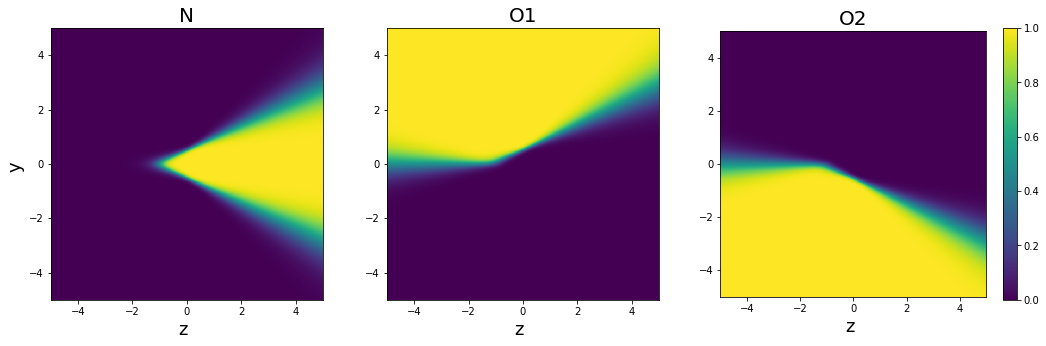

In [196]:
fig = plt.figure(figsize=(18,5))
gs = gridspec.GridSpec(1, 3,
                       width_ratios=[1,1,1.2],hspace=0.5
                       )
#left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
#ax1 = fig.add_axes([left, bottom, width, height])
ax1 = plt.subplot(gs[0])
ax1.imshow(wb1,aspect='equal',extent=[-5,5,-5,5],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))
ax2 = plt.subplot(gs[1])
ax2.imshow(wb2,aspect='equal',extent=[-5,5,-5,5],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))
ax3 = plt.subplot(gs[2])
cp=ax3.imshow(wb3,aspect='equal',extent=[-5,5,-5,5],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))
plt.colorbar(cp)

ax1.set_title('N', Fontsize=20)
ax1.set_xlabel('z ', Fontsize=18)
ax1.set_ylabel('y ',Fontsize=18)
ax2.set_title('O1', Fontsize=20)
ax2.set_xlabel('z ', Fontsize=18)
ax3.set_title('O2', Fontsize=20)
ax3.set_xlabel('z ', Fontsize=18)
plt.savefig('Fig-BeckeTriatomicNO2.pdf', bbox_inches='tight')

In [213]:
radii = [2., 2., 2.]
wc, bw = modify_becke(pt,w,cen,radii)

(250000, 3)


In [214]:
w1 = [item[0] for item in bw ]
w2 = [item[1] for item in bw ]
w3 = [item[2] for item in bw ]

wb1=numpy.reshape(w1, (len(grid_z[0]), len(grid_z)))
wb2 = numpy.reshape(w2, (len(grid_z[0]), len(grid_z)))
wb3 = numpy.reshape(w3, (len(grid_z[0]), len(grid_z)))
w0  = numpy.reshape(wc, (len(grid_z[0]), len(grid_z)))

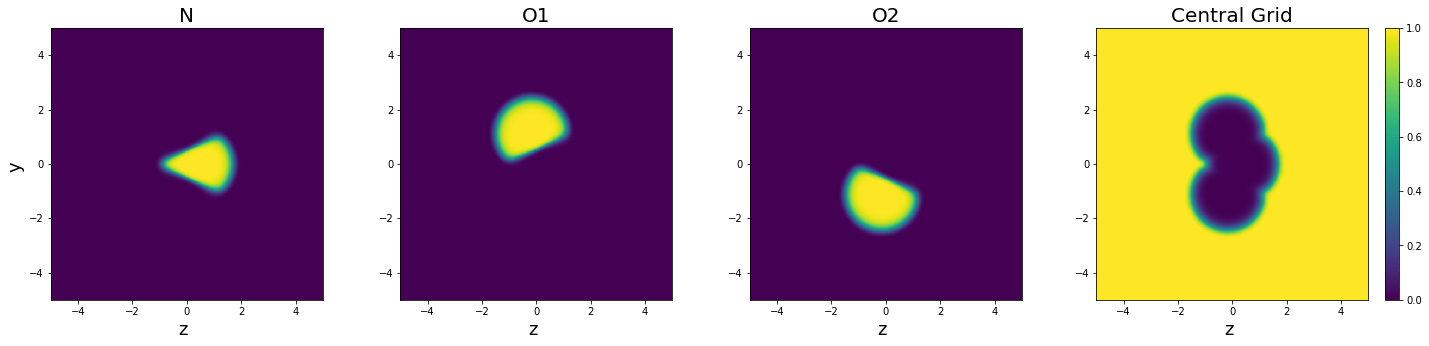

In [215]:
fig = plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(1, 4,
                       width_ratios=[1,1,1,1.2],hspace=0.5
                       )
#left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
#ax1 = fig.add_axes([left, bottom, width, height])
ax1 = plt.subplot(gs[0])
ax1.imshow(wb1,aspect='equal',extent=[-5,5,-5,5],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))
ax2 = plt.subplot(gs[1])
ax2.imshow(wb2,aspect='equal',extent=[-5,5,-5,5],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))
ax3 = plt.subplot(gs[2])
ax3.imshow(wb3,aspect='equal',extent=[-5,5,-5,5],origin=[0,0], vmin=0., vmax=1.0)
ax4 = plt.subplot(gs[3])
cp=ax4.imshow(w0,aspect='equal',extent=[-5,5,-5,5],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))
plt.colorbar(cp)

ax1.set_title('N', Fontsize=20)
ax1.set_xlabel('z ', Fontsize=18)
ax1.set_ylabel('y ',Fontsize=18)
ax2.set_title('O1', Fontsize=20)
ax2.set_xlabel('z ', Fontsize=18)
ax3.set_title('O2', Fontsize=20)
ax3.set_xlabel('z ', Fontsize=18)
ax4.set_title('Central Grid', Fontsize=20)
ax4.set_xlabel('z ', Fontsize=18)

plt.savefig('Fig-BeckeTriatomicNO2_scheme1.pdf', bbox_inches='tight')

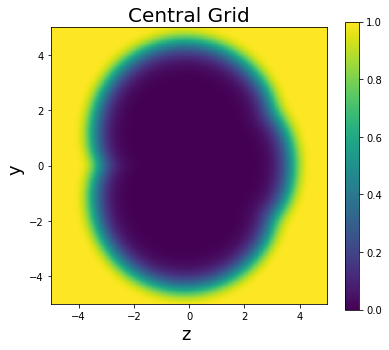

In [200]:
fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])
cp = plt.imshow( w0,aspect='equal',extent=[-5,5,-5,5],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))
plt.colorbar(cp)

ax.set_title('Central Grid', Fontsize=20)
ax.set_xlabel('z ', Fontsize=18)
ax.set_ylabel('y ',Fontsize=18)
plt.show()

In [210]:
radii = [5., 5., 5.]
wc, bw = modify_becke2(pt,w,cen,radii)
w1 = [item[0] for item in bw ]
w2 = [item[1] for item in bw ]
w3 = [item[2] for item in bw ]

wb1=numpy.reshape(w1, (len(grid_z[0]), len(grid_z)))
wb2 = numpy.reshape(w2, (len(grid_z[0]), len(grid_z)))
wb3 = numpy.reshape(w3, (len(grid_z[0]), len(grid_z)))
w0  = numpy.reshape(wc, (len(grid_z[0]), len(grid_z)))

(250000, 3)


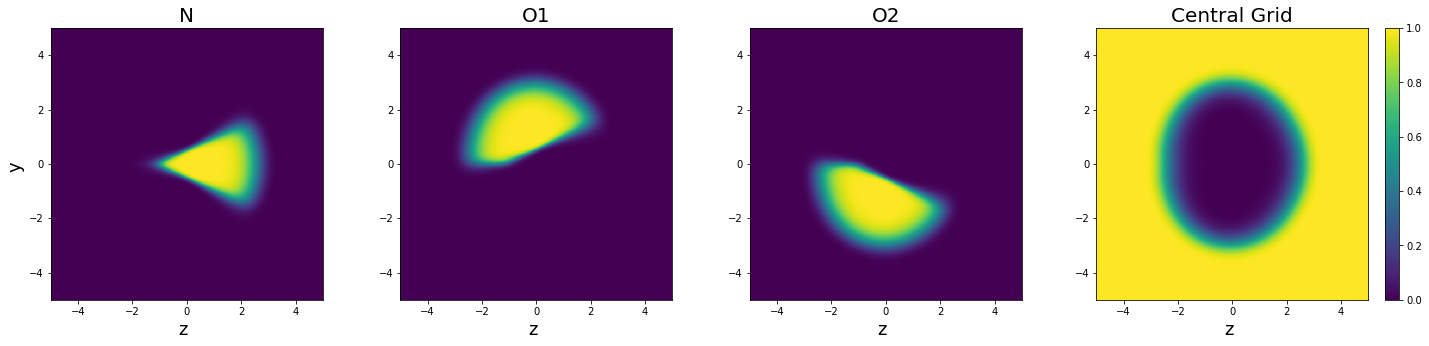

In [212]:
fig = plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(1, 4,
                       width_ratios=[1,1,1,1.2],hspace=0.5
                       )
#left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
#ax1 = fig.add_axes([left, bottom, width, height])
ax1 = plt.subplot(gs[0])
ax1.imshow(wb1,aspect='equal',extent=[-5,5,-5,5],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))
ax2 = plt.subplot(gs[1])
ax2.imshow(wb2,aspect='equal',extent=[-5,5,-5,5],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))
ax3 = plt.subplot(gs[2])
ax3.imshow(wb3,aspect='equal',extent=[-5,5,-5,5],origin=[0,0], vmin=0., vmax=1.0)
ax4 = plt.subplot(gs[3])
cp=ax4.imshow(w0,aspect='equal',extent=[-5,5,-5,5],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))
plt.colorbar(cp)

ax1.set_title('N', Fontsize=20)
ax1.set_xlabel('z ', Fontsize=18)
ax1.set_ylabel('y ',Fontsize=18)
ax2.set_title('O1', Fontsize=20)
ax2.set_xlabel('z ', Fontsize=18)
ax3.set_title('O2', Fontsize=20)
ax3.set_xlabel('z ', Fontsize=18)
ax4.set_title('Central Grid', Fontsize=20)
ax4.set_xlabel('z ', Fontsize=18)

plt.savefig('Fig-BeckeTriatomicNO2_scheme2.pdf', bbox_inches='tight')

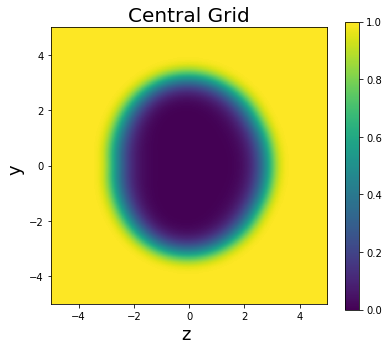

In [203]:
fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])
cp = plt.imshow( w0,aspect='equal',extent=[-5,5,-5,5],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))
plt.colorbar(cp)

ax.set_title('Central Grid', Fontsize=20)
ax.set_xlabel('z ', Fontsize=18)
ax.set_ylabel('y ',Fontsize=18)
plt.show()